In [1]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
from sklearn.preprocessing import normalize
import pandas as pd
from tqdm.notebook import tqdm

from PIL import Image

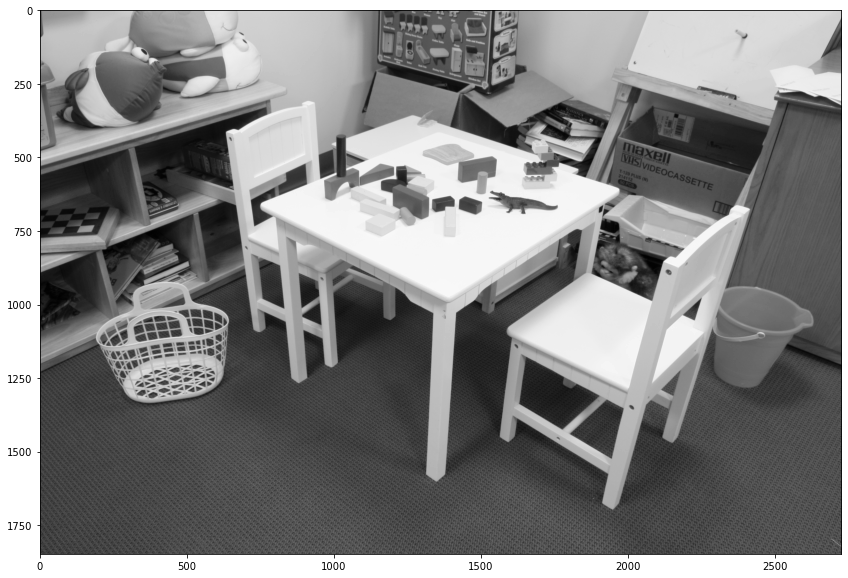

In [2]:
fig, ax = plt.subplots(figsize=(20, 10))

imgL = cv.imread('data/Middlebury/Playtable-perfect/im0.png')
imgL = cv.cvtColor(imgL, cv.COLOR_BGR2GRAY)

imgR = cv.imread('data/Middlebury/Playtable-perfect/im1.png')
imgR = cv.cvtColor(imgR, cv.COLOR_BGR2GRAY)

plt.imshow(imgL, 'gray')
plt.show()

## Convolução 1d para achar pedaço mais similar a um vetor de pontos em uma linha

In [3]:
def find_least_different_in_line(search_points, line):
    line_squared = line**2
    search_points_squared_sum = np.sum(search_points**2)
    nBuf = len(search_points)
    cross_terms = -2*np.convolve(line, search_points[::-1], "valid")
    
    squared_distance = [search_points_squared_sum + np.sum(line_squared[i:i+nBuf]) + cross_terms[i] 
                        for i in range(len(cross_terms))]
    
    mean_squared_distance = np.array(squared_distance)/nBuf
    
    ## Retorna a média da localização dos 3 pontos mais similares
    x_start_right_image = np.mean(pd.Series(mean_squared_distance).nsmallest(3).index)    
    return int(x_start_right_image)


## Test

In [4]:
# Linha 250
# pontos 0 a 250
line = 1200
search_points = imgL[line,0:250]

line =imgR[line,:]

response = find_least_different_in_line(search_points,line)
response

1739

### 

### separa a imagem em janelas que nao se cruzam e testa so com essas janelas

In [5]:
def get_line_disparity(line_number, window_size):
# line_number = 500
# window_size = 50
    n_windows = int(imgL.shape[1]/window_size)
    disparity_array = []
    #coloca para ele avançar de 2 em 2 pixels, senão ng aguenta
    for window in range(0,n_windows,2):
        #print(window)
        #print('start index:',window*window_size )
        #print('end index:', (window + 1)*window_size )
        start_index = window * window_size
        end_index = (window + 1) * window_size
        search_points = imgL[line_number,start_index:end_index]
        epipolar_line = imgR[line_number,:end_index]
        point_position_right_image = find_least_different_in_line(search_points,epipolar_line)
        #print(point_position_right_image)
        disparity = np.abs(start_index - point_position_right_image)
        disparity_array.append(disparity)
    return disparity_array

### usa janelas com interseção

In [6]:
def get_line_disparity(line_number, window_size):
    #n_windows = int(imgL.shape[1]/window_size)
    pixels_y = imgL.shape[1]
    disparity_array = []
    for window in range(pixels_y - window_size):

        start_index = window
        end_index = window+window_size

        search_points = imgL[line_number,start_index:end_index]
        epipolar_line = imgR[line_number,:end_index]
        point_position_right_image = find_least_different_in_line(search_points,epipolar_line)
        #print(point_position_right_image)
        disparity = np.abs(start_index - point_position_right_image)
        disparity_array.append(disparity)
    return disparity_array

## For

In [7]:
# get_line_disparity(500, 50)

In [8]:
window_size = 10
disparity_map = []
for line in tqdm(range(imgL.shape[0])):
#for line in tqdm(range(100)):
    disparity_map.append(get_line_disparity(line, window_size))

  0%|          | 0/1848 [00:00<?, ?it/s]

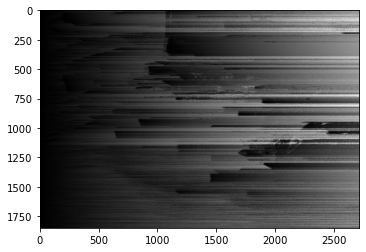

In [9]:
plt.imshow(np.array(disparity_map), 'gray')
plt.show()

In [10]:
disparity = np.array(disparity_map, dtype=np.uint8)
print(disparity.shape)

(1848, 2714)


In [11]:
img = Image.fromarray(disparity)
img.save('disparity.png')
